# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import morphology
import matplotlib.image as mpimg
import random
from sklearn.cluster import KMeans
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from PIL import ImageColor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import morphology
import matplotlib.image as mpimg
import random
from sklearn.cluster import KMeans
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from PIL import ImageColor

# Loading data

In [2]:
features = pd.read_csv(r'../features/features.csv')
ground_truth = pd.read_csv(r"../data/example_ground_truth.csv")


# Functions

In [3]:
def calculate_area(image):
    """
    image = a numpy array
    """
    return np.sum(image)

def calculate_border(image,thickness):
    """
    image = np array of a picture
    thicness = an integer of the thiccness of the border
    returns = the border of the figure
    """
    struct_el = morphology.disk(thickness)
    mask_eroded = morphology.binary_erosion(image, struct_el)
    return calculate_area(image)-np.sum(mask_eroded)


def compactness(area, border):
    """
    area = the area of the figure
    border = the circumference of the figure
    return = returns the compactness
    """
    top = border**2
    bot = 4*math.pi*area
    return top/bot

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))



def average_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.mean(copy[mask,0])
    g = np.mean(copy[mask,1])
    b = np.mean(copy[mask,2])
    #num_of_pixels = copy[mask].shape[0]
    return [r,g,b]

def deviation_of_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.std(copy[mask,0])
    g = np.std(copy[mask,1])
    b = np.std(copy[mask,2])
    return [r,g,b]

def average_luminosity(image,segmentation):
    avg_colour = average_colour(image,segmentation)
    return 0.299*avg_colour[0] + 0.587*avg_colour[1] + 0.114*avg_colour[2]

def deviation_luminosity(image,segmentation):
    deviation_colour = deviation_of_colour(image,segmentation)
    return np.sqrt(0.299**2*deviation_colour[0]**2 + 0.587**2*deviation_colour[1]**2 + 0.114**2*deviation_colour[2]**2)

def findImage(image_id):
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    return image,image_seg

def make_knn_prediction(k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train, y_train)
    return neigh.predict(x_test)

def from_rgb_to_int(df):
    placeholder = [RGB2HEX(elm) for elm in df]
    hex_val = [int("0x" + elm[1:],0) for elm in placeholder]
    return hex_val

def knn_model_constructor(k,training,labels):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(training, labels)
    return model

# Task 0: Exploring the data

In [4]:
#rename column 'id' to 'image_id'
features.rename(columns={'id': 'image_id'}, inplace=True)

In [5]:
# Here we merge the two data frames
all_feature_merge = features.merge(ground_truth, on='image_id', how='right')

In [6]:
# Here we plot the dataframe
all_feature_merge

,image_id,area,perimeter,melanoma,seborrheic_keratosis
0,ISIC_0001769,216160.0,2013.0,0.0,0.0
1,ISIC_0001852,130493.0,1372.0,0.0,0.0
2,ISIC_0001871,205116.0,1720.0,0.0,0.0
3,ISIC_0003462,161705.0,1344.0,0.0,0.0
4,ISIC_0003539,317040.0,2063.0,0.0,0.0
...,...,...,...,...,...
145,ISIC_0015443,9732988.0,13775.0,0.0,0.0
146,ISIC_0015445,12049938.0,19517.0,0.0,0.0
147,ISIC_0015483,8856478.0,13813.0,0.0,0.0
148,ISIC_0015496,8951522.0,13742.0,0.0,0.0


In [7]:
# Here we check for missing values, which we do not have
all_feature_merge.isna().any()

image_id                False
area                    False
perimeter               False
melanoma                False
seborrheic_keratosis    False
dtype: bool

# Task 1: implement two features

In [8]:
# Here we are creating masks for which we are going to sort our data

In [9]:
mask = ground_truth['melanoma'] == 1
melanoma_mask = ground_truth[mask]

In [10]:
mask = ground_truth['seborrheic_keratosis'] == 1
keratosis_mask = ground_truth[mask]

In [11]:
# Here we create a couple lists with the data
# the structure of the lists are [("Image_id", "np_array of the picture", "np_array of the mask")]

In [12]:
total_data = []
melanoma_data = []
keratosis_data = []
non_infected_data = []
x = 0

for image_id in ground_truth['image_id']:
    print(image_id,x)
    image = plt.imread('../data/example_image/'+image_id+'.jpg') # Here we load the image
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png') # Here we load the mask
    if image_id in list(melanoma_mask['image_id']): # If the image id is in the melanoma list, label it as melanoma
        melanoma_data.append((image_id,image,image_seg)) #else label it as keratosis
    if image_id in list(keratosis_mask['image_id']):
        keratosis_data.append((image_id,image,image_seg))
    if (image_id not in list(keratosis_mask['image_id'])) and (image_id not in list(melanoma_mask['image_id'])): # If the image id is in the melanoma list, label it as melanoma
        non_infected_data.append((image_id,image,image_seg))
    total_data.append((image_id,image,image_seg)) #Here we have a list of all the data together
    x += 1

ISIC_0001769 0
ISIC_0001852 1
ISIC_0001871 2
ISIC_0003462 3
ISIC_0003539 4
ISIC_0003582 5
ISIC_0003657 6
ISIC_0003805 7
ISIC_0004337 8
ISIC_0006651 9
ISIC_0006671 10
ISIC_0006815 11
ISIC_0006914 12
ISIC_0007141 13
ISIC_0007156 14
ISIC_0007235 15
ISIC_0007241 16
ISIC_0007332 17
ISIC_0007344 18
ISIC_0007528 19
ISIC_0007796 20
ISIC_0008025 21
ISIC_0008524 22
ISIC_0009995 23
ISIC_0010459 24
ISIC_0012099 25
ISIC_0012109 26
ISIC_0012126 27
ISIC_0012127 28
ISIC_0012143 29
ISIC_0012151 30
ISIC_0012159 31
ISIC_0012160 32
ISIC_0012191 33
ISIC_0012201 34
ISIC_0012204 35
ISIC_0012206 36
ISIC_0012210 37
ISIC_0012221 38
ISIC_0012222 39
ISIC_0012254 40
ISIC_0012256 41
ISIC_0012288 42
ISIC_0012306 43
ISIC_0012313 44
ISIC_0012316 45
ISIC_0012335 46
ISIC_0012380 47
ISIC_0012383 48
ISIC_0012400 49
ISIC_0012417 50
ISIC_0012434 51
ISIC_0012492 52
ISIC_0012513 53
ISIC_0012538 54
ISIC_0012547 55
ISIC_0012660 56
ISIC_0012684 57
ISIC_0012720 58
ISIC_0012746 59
ISIC_0012876 60
ISIC_0012927 61
ISIC_0012956 62
IS

In [13]:
# Here we get the id of the first legion
melanoma_data[0][0]

'ISIC_0012099'

In [14]:
# Here we create the mask
id_mask = all_feature_merge['image_id'] == 'ISIC_0012099'

In [15]:
area = calculate_area(melanoma_data[0][2])

In [16]:
print("Here is the actual area {} and here is the computed area".format(int(all_feature_merge[id_mask]['area'])), area)

Here is the actual area 88455 and here is the computed area 88455.0


In [17]:
# This shows us that our function is correct. This is important because we are using the 
# calculate_area function in the perimeter Function

In [18]:
# Now we compare our border function

In [19]:
border = calculate_border(melanoma_data[0][2],1)

In [20]:
print("Here is the actual area {} and here is the computed area".format(int(all_feature_merge[id_mask]['perimeter'])), border)

Here is the actual area 1353 and here is the computed area 1353.0


In [21]:
# Now we are going to compute the compactness

In [22]:
print("Legion: {} Compactness: {}".format(melanoma_data[0][0],compactness(area,border)))

Legion: ISIC_0012099 Compactness: 1.6468852592759675


# Task 02

In [23]:
label = []
for elm in zip(all_feature_merge['melanoma'],all_feature_merge['seborrheic_keratosis']):
    
    if elm[0] == 1.0:
        #print("hej")
        label.append(1.0)
    if elm[1] == 1.0:
        label.append(2.0)
    if (elm[0] == 0.0) and (elm[1] == 0.0):
        label.append(0)
    #print(type(elm[0]))
#len(label)
all_feature_merge['label'] = label

In [24]:

#Export features from images
data = pd.DataFrame()
count = 0
rows = []
for image_id in all_feature_merge['image_id']:
    print(image_id,count)
    
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    #data['image_id'] = image_id
    real_area = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['area'])
    real_perimeter = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['perimeter'])
    thing = all_feature_merge['image_id'] == image_id
    label = int(all_feature_merge[thing]['label'])

    calculated_area = int(calculate_area(image_seg))
    calculated_perimeter = calculate_border(image_seg,2)
    imgCompactness = compactness(calculate_area(image_seg),calculate_border(image_seg,1))
    average_rgb = average_colour(image,image_seg)
    deviation_of_rgb = deviation_of_colour(image,image_seg)
    average_luminosity_img = average_luminosity(image,image_seg)
    deviation_luminosity_img = deviation_luminosity(image,image_seg)
    row = [label,image_id, real_area, real_perimeter,calculated_area,calculated_perimeter,imgCompactness,average_rgb,deviation_of_rgb,average_luminosity_img,deviation_luminosity_img]
    rows.append(row)
    count+= 1

data = pd.DataFrame(rows, columns = ['label','image_id','real_area','real_perimeter','calculated_area','calculated_perimeter','compactness','average_rgb','deviation_of_colour','average_luminosity','deviation_luminosity'])

ISIC_0001769 0
ISIC_0001852 1
ISIC_0001871 2
ISIC_0003462 3
ISIC_0003539 4
ISIC_0003582 5
ISIC_0003657 6
ISIC_0003805 7
ISIC_0004337 8
ISIC_0006651 9
ISIC_0006671 10
ISIC_0006815 11
ISIC_0006914 12
ISIC_0007141 13
ISIC_0007156 14
ISIC_0007235 15
ISIC_0007241 16
ISIC_0007332 17
ISIC_0007344 18
ISIC_0007528 19
ISIC_0007796 20
ISIC_0008025 21
ISIC_0008524 22
ISIC_0009995 23
ISIC_0010459 24
ISIC_0012099 25
ISIC_0012109 26
ISIC_0012126 27
ISIC_0012127 28
ISIC_0012143 29
ISIC_0012151 30
ISIC_0012159 31
ISIC_0012160 32
ISIC_0012191 33
ISIC_0012201 34
ISIC_0012204 35
ISIC_0012206 36
ISIC_0012210 37
ISIC_0012221 38
ISIC_0012222 39
ISIC_0012254 40
ISIC_0012256 41
ISIC_0012288 42
ISIC_0012306 43
ISIC_0012313 44
ISIC_0012316 45
ISIC_0012335 46
ISIC_0012380 47
ISIC_0012383 48
ISIC_0012400 49
ISIC_0012417 50
ISIC_0012434 51
ISIC_0012492 52
ISIC_0012513 53
ISIC_0012538 54
ISIC_0012547 55
ISIC_0012660 56
ISIC_0012684 57
ISIC_0012720 58
ISIC_0012746 59
ISIC_0012876 60
ISIC_0012927 61
ISIC_0012956 62
IS

In [25]:
data

,label,image_id,real_area,real_perimeter,calculated_area,calculated_perimeter,compactness,average_rgb,deviation_of_colour,average_luminosity,deviation_luminosity
0,0,ISIC_0001769,216160,2013,216160,3982.0,1.491772,"[162.07149333826794, 99.30780440414507, 67.786...","[12.205123532436513, 18.754262929408846, 19.89...",114.480686,11.817479
1,0,ISIC_0001852,130493,1372,130493,2718.0,1.147919,"[116.74907466300874, 54.64894668679546, 33.087...","[31.27789052350099, 32.07510414646571, 25.0998...",70.758871,21.216643
2,0,ISIC_0001871,205116,1720,205116,3412.0,1.147751,"[182.21681390042707, 134.7412049766961, 102.53...","[6.3898744270946, 12.975379982675513, 19.33878...",145.265327,8.156129
3,0,ISIC_0003462,161705,1344,161705,2683.0,0.888925,"[165.82234315574658, 116.78643826721499, 87.55...","[13.467871330386464, 27.312125552850148, 34.95...",128.115611,17.003706
4,0,ISIC_0003539,317040,2063,317040,4120.0,1.068254,"[165.12712276053495, 99.63897930860459, 63.168...","[23.770632535623616, 33.005983134923085, 30.47...",115.062269,20.927490
...,...,...,...,...,...,...,...,...,...,...,...
145,0,ISIC_0015443,9732988,13775,9732988,27463.0,1.551412,"[139.39421737702747, 89.18466076399149, 63.660...","[14.693926319508012, 21.175403762962702, 27.40...",101.287584,13.548701
146,0,ISIC_0015445,12049938,19517,12049938,39025.0,2.515541,"[154.57732197460268, 91.72927727926898, 82.038...","[47.62813987684408, 41.48168846201185, 40.1837...",109.416063,28.577897
147,0,ISIC_0015483,8856478,13813,8856478,27534.0,1.714372,"[142.42447065300675, 105.85834335048311, 92.20...","[38.30387070156361, 34.627307043981304, 33.481...",115.234832,23.640907
148,0,ISIC_0015496,8951522,13742,8951522,27392.0,1.678778,"[172.3990948131502, 98.74436403105528, 77.7044...","[71.20114045798132, 56.41305374592664, 50.9847...",118.368574,39.794190


In [26]:
# Here we create a backup of the data, since the creating of the dataframe is really time consuming
backup = data.copy()

# Testing and cross validation

### Test 01 without the color

In [27]:
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])
data = data.drop(columns = ['average_rgb','deviation_of_colour'])

In [28]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])

In [29]:
# Here we get the labels
label = np.array(data.iloc[:,0:1])

In [30]:
# Here we convert the labels to integers
label = [int(x) for x in label]

In [31]:
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)

In [32]:
# x_train is the training data
# y_train is the training labels
# x_test is the testing data
# y_test is the testing labels

In [33]:
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

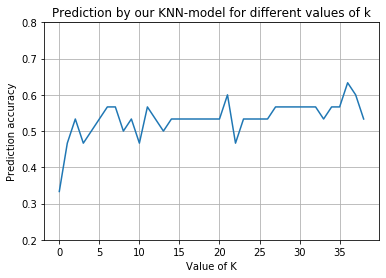

In [34]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [35]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)

In [36]:
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)

In [37]:
scores

array([0.48387097, 0.5483871 , 0.56666667, 0.48275862, 0.20689655])

In [38]:
# Here we print the average score from the cross validation
sum(scores)/5

0.45771598071931774

### Test 02 same test but we use the log on the data

In [39]:
data = backup.copy()

In [40]:
data = backup.copy()
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])
data = data.drop(columns = ['average_rgb','deviation_of_colour'])

In [41]:
#Since compactness are such low values, there is no need to take the log of it
for elm in data.iloc[:,2:]:
    if max(data[elm]) > max(data['compactness']):
        data[elm] = np.log10(data[elm])

In [42]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])
# Here we get the labels
label = np.array(data.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

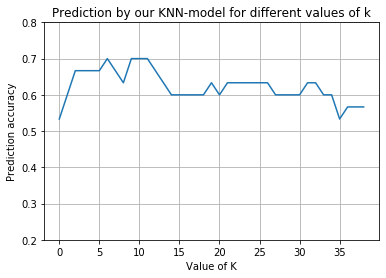

In [43]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [44]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

0.5355654430849092

### Test 03 here we use the color and convert it to an int

In [45]:
data = backup.copy()
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])

In [46]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(data['average_rgb'])
data['average_rgb'] = hex_val
hex_val = from_rgb_to_int(data['deviation_of_colour'])
data['deviation_of_colour'] = hex_val

In [47]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])
# Here we get the labels
label = np.array(data.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

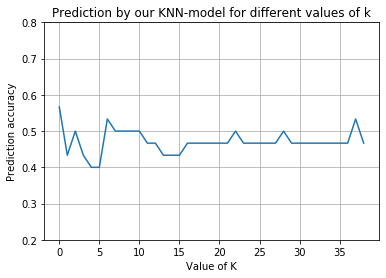

In [48]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [49]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

0.5324582869855395

### Test 04 here we use the color and convert it to an int and taking the log

In [50]:
data = backup.copy()
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])

In [51]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(data['average_rgb'])
data['average_rgb'] = hex_val
hex_val = from_rgb_to_int(data['deviation_of_colour'])
data['deviation_of_colour'] = hex_val

In [52]:
#Since compactness are such low values, there is no need to take the log of it
for elm in data.iloc[:,2:]:
    if max(data[elm]) > max(data['compactness']):
        data[elm] = np.log10(data[elm])

In [53]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])
# Here we get the labels
label = np.array(data.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

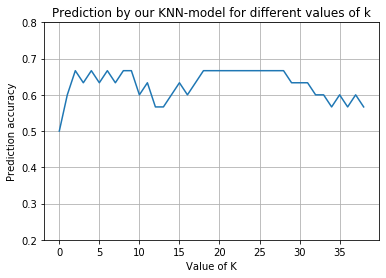

In [54]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [55]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

0.5300037078235076

### Test 05 binary classification

In [56]:
binary_df = backup.copy()

So here we want to try something a bit different.
Our hypethesis is that, melanoma and keratosis has a lot in common, so maybe it will be easier,
if we try and predict wether the input is "normal" or "not normal"
Then after we then want to try and classify wether it is keratosis or melanoma.
Since the space is a lot closer when only using keratosis or melanoma, it should be easier to distinguish.

In [57]:
# Here we convert melanoma and keratosis to 1 and everything else as 0.
# 
label = []
for elm in zip(all_feature_merge['melanoma'],all_feature_merge['seborrheic_keratosis']):
    
    if elm[0] == 1.0 or elm[1] == 1.0:
        #print("hej")
        label.append(1.0)
    else:
        label.append(0.0)
    
binary_df['label'] = label

In [58]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(binary_df['average_rgb'])
binary_df['average_rgb'] = hex_val
hex_val = from_rgb_to_int(binary_df['deviation_of_colour'])
binary_df['deviation_of_colour'] = hex_val

In [59]:
#Since compactness are such low values, there is no need to take the log of it
for elm in binary_df.iloc[:,2:]:
    if max(binary_df[elm]) > max(binary_df['compactness']):
        binary_df[elm] = np.log10(binary_df[elm])

In [60]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(binary_df.iloc[:,2:11])
# Here we get the labels
label = np.array(binary_df.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

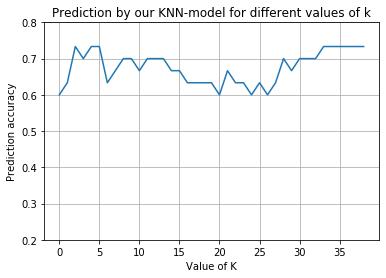

In [61]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [62]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

0.602536151279199

In [63]:
#This here is the score when comparing sick vs non sick

In [64]:
#Now we want to try and classify wether something is melanoma or keratosis

In [65]:
data = backup.copy()

In [66]:
data = data.drop(columns = ['calculated_area','calculated_perimeter'])

In [67]:
mask = (data['label'] == 1) | (data['label'] == 2)

In [68]:
sick_df = data[mask]

In [69]:
sick_df

,label,image_id,real_area,real_perimeter,compactness,average_rgb,deviation_of_colour,average_luminosity,deviation_luminosity
25,1,ISIC_0012099,88455,1353,1.646885,"[133.0839409869425, 74.67328019897123, 63.3797...","[43.84185609572144, 42.9906194601899, 39.70560...",90.850600,28.795090
29,2,ISIC_0012143,1124326,5267,1.963471,"[125.36867865725777, 87.89170845466528, 81.978...","[11.614667474218335, 16.009279535790448, 18.58...",98.423235,10.240129
30,1,ISIC_0012151,1558295,5920,1.789715,"[154.00267150956654, 101.85409630397325, 69.64...","[12.488177086059158, 22.763660597504117, 21.36...",113.774431,14.086425
35,2,ISIC_0012204,171424,1427,0.945293,"[165.94577772073922, 106.19560854956133, 80.87...","[8.13084162136855, 14.007302634806843, 14.7728...",121.174759,8.737996
37,2,ISIC_0012210,791881,4846,2.359919,"[184.94340690078434, 144.15536299014624, 115.0...","[2.920282092086682, 7.261667373682666, 9.57901...",153.030320,4.486050
...,...,...,...,...,...,...,...,...,...
133,1,ISIC_0014985,17073688,19027,1.685570,"[123.99294470360199, 74.21463463861197, 67.689...","[20.873873774856392, 24.070746008934705, 23.84...",88.354444,15.683895
136,2,ISIC_0015062,27706864,23002,1.524509,"[121.0199836307492, 91.65647917749658, 92.6513...","[49.93624354724213, 43.18833669980172, 45.3151...",100.549579,29.871742
137,1,ISIC_0015124,12048040,17115,1.934762,"[167.42364592083027, 106.60566266380258, 82.31...","[44.26718597621176, 46.94699940844143, 48.1454...",122.020931,31.060434
140,1,ISIC_0015243,19736156,18599,1.394183,"[148.02007472578254, 87.64673654854845, 79.589...","[32.9952937356417, 29.808602609479337, 35.3989...",104.779859,20.488601


In [70]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(sick_df['average_rgb'])
sick_df['average_rgb'] = hex_val
hex_val = from_rgb_to_int(sick_df['deviation_of_colour'])
sick_df['deviation_of_colour'] = hex_val

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [71]:
#Since compactness are such low values, there is no need to take the log of it
for elm in sick_df.iloc[:,2:]:
    if max(sick_df[elm]) > max(sick_df['compactness']):
        sick_df[elm] = np.log10(sick_df[elm])

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [72]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(sick_df.iloc[:,2:11])
# Here we get the labels
label = np.array(sick_df.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

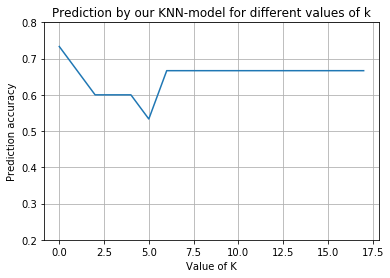

In [73]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [74]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

0.6533333333333333